---

# <center> Big Data Project - Face and emotions Recognition 

---

### Description:

A Convolutional Neural Network (CNN) model for facial expression recognition is specifically designed to analyze facial images and predict the emotions based on the expressions displayed.

To train the CNN model, a large dataset of labeled facial images with corresponding emotion labels is required. The model is trained using an optimization algorithm that adjusts the internal parameters of the network to minimize the difference between predicted and true emotion labels. This process involves feeding the training data through the network, computing the loss, and updating the model's parameters using techniques like backpropagation and gradient descent.

Once trained, the CNN model can be used to recognize facial expressions and predict the emotions of new, unseen faces. It provides a valuable tool for understanding and analyzing human emotions, with applications in areas such as psychology, human-computer interaction, social robotics, and market research.

### Objective:
- To accurately face recognition using Computer Vision + Deep Learning technique.
- To accurately emotion recognition based on facial expressions using Computer Vision + Deep Learning technique.

---

# <center>   Code Implementation:

### 1. Importing the basic libraries

In [1]:
# Importing the basic libraries

import cv2
import math
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD

import warnings 
warnings.filterwarnings('ignore')

import urllib
import os

!pip install mplcyberpunk
import mplcyberpunk

### 2. Reading the Image

In [2]:
# Defining the path for train and test images

Train_dir = pathlib.Path('../input/avengers-faces-dataset/images/train')
Test_dir = pathlib.Path('../input/avengers-faces-dataset/images/test')
Val_dir = pathlib.Path('../input/avengers-faces-dataset/images/val')

image_count_train = len(list(Train_dir.glob('*/*.png')))
print("Training Samples ---> ",image_count_train)

image_count_test = len(list(Test_dir.glob('*/*.png')))
print("Testing Samples ---> ",image_count_test)

image_count_val = len(list(Val_dir.glob('*/*.png')))
print("Testing Samples ---> ",image_count_val)

Training Samples --->  274
Testing Samples --->  60
Testing Samples --->  60


In [3]:
#Defining constants

random_seed=123
batch_size = 32
img_height = 180
img_width = 180

In [4]:
# Training Set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(Train_dir,
                                                               seed=random_seed,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

# Testing Set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(Test_dir,
                                                               seed=random_seed,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

# Validation Set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(Val_dir,
                                                               seed=random_seed,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 274 files belonging to 5 classes.
Found 60 files belonging to 5 classes.
Found 60 files belonging to 5 classes.


### 3. Exploring Dataset

In [5]:
# Listing all the classes

class_names = train_ds.class_names
class_map={}
name_class_map={"chris_evans":"Chris_Evans", "chris_hemsworth":"Chris_Hemsworth", "mark_ruffalo":"Mark_Ruffalo", 
"robert_downey_jr":"Robert_Downey_Jr", "scarlett_johansson":"Scarlett_Johansson"}

for i in range(len(class_names)):
    class_map[i]=class_names[i]
class_map

{0: 'chris_evans',
 1: 'chris_hemsworth',
 2: 'mark_ruffalo',
 3: 'robert_downey_jr',
 4: 'scarlett_johansson'}

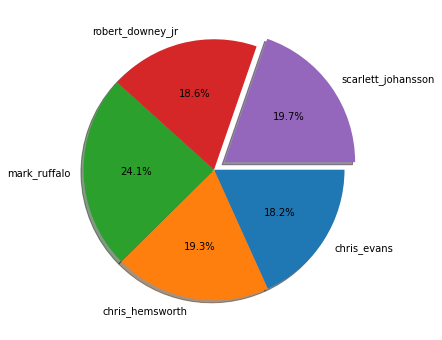

In [6]:
#Visualizing Data Classes Distribution

class_count = []
for i in range(len(class_names)):
    class_count.append(len(list(Train_dir.glob('{}/*.png'.format(class_names[i])))))

    
plt.pie(class_count, shadow=True, startangle=0, explode=[0,0,0,0,0.1], autopct='%1.1f%%', counterclock=False, labels=train_ds.class_names)
#, labels=class_map.values())
plt.show()

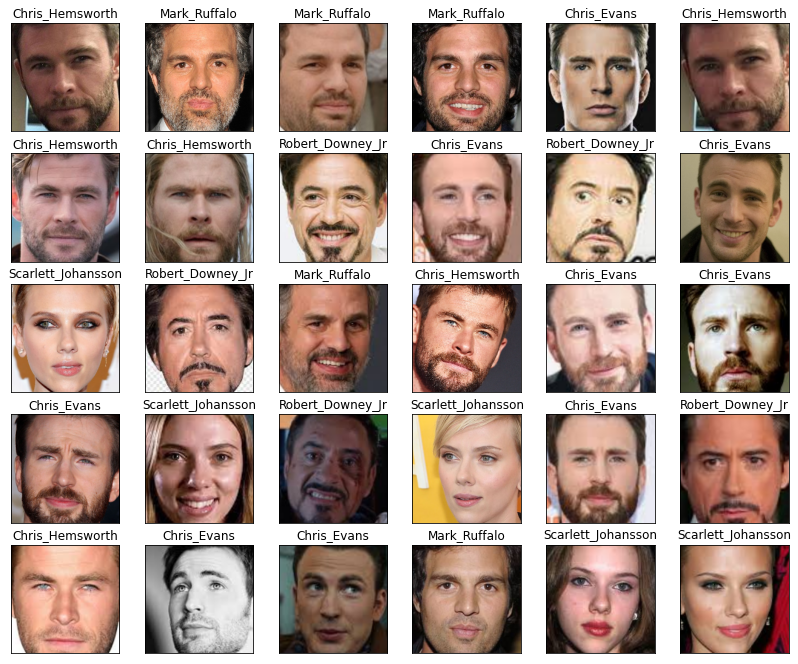

In [7]:
#Visualising a batch of image dataset

plt.figure(figsize=[14,14])
for image, label in train_ds.take(1):
    for e,i in enumerate(image):
        if e<30:
            plt.subplot(6,6,e+1)
            plt.imshow(i.numpy().astype('uint8'))
            plt.title(name_class_map[class_map[label[e].numpy()]])
            plt.xticks([])
            plt.yticks([])
plt.show()

In [8]:
# Staging the Dataset

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 4. DL Model Training

In [9]:
# Develop a sequential model using tensorflow keras

face_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width,3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, (3, 3), padding="same", activation="relu" ),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu" ),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu" ),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

face_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

face_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [10]:
# Training the model

chkpt = ModelCheckpoint('checkpoints/best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.01)

epochs=25
history_1 = face_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[es, chkpt])

Epoch 1/25
9/9 [==============================] - 12s 159ms/step - loss: 1.8138 - accuracy: 0.2263 - val_loss: 1.5966 - val_accuracy: 0.3000

Epoch 00001: val_loss improved from inf to 1.59662, saving model to checkpoints/best_model.h5
Epoch 2/25
9/9 [==============================] - 0s 20ms/step - loss: 1.5913 - accuracy: 0.3029 - val_loss: 1.5332 - val_accuracy: 0.3833

Epoch 00002: val_loss improved from 1.59662 to 1.53321, saving model to checkpoints/best_model.h5
Epoch 3/25
9/9 [==============================] - 0s 21ms/step - loss: 1.4588 - accuracy: 0.4526 - val_loss: 1.2477 - val_accuracy: 0.6167

Epoch 00003: val_loss improved from 1.53321 to 1.24766, saving model to checkpoints/best_model.h5
Epoch 4/25
9/9 [==============================] - 0s 20ms/step - loss: 1.2020 - accuracy: 0.5912 - val_loss: 1.0177 - val_accuracy: 0.7000

Epoch 00004: val_loss improved from 1.24766 to 1.01772, saving model to checkpoints/best_model.h5
Epoch 5/25
9/9 [==============================] - 

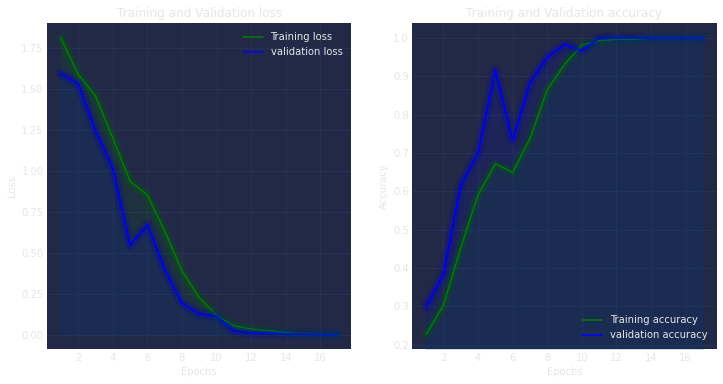

In [11]:
#Visualising model performance
acc_train = history_1.history['accuracy']
acc_val = history_1.history['val_accuracy']

loss_train = history_1.history['loss']
loss_val = history_1.history['val_loss']

epochs = range(1,len(loss_train)+1)
plt.figure(figsize=(12, 6))
plt.style.use('cyberpunk')
plt.subplot(1,2,1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
mplcyberpunk.add_glow_effects()

plt.subplot(1,2,2)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
mplcyberpunk.add_glow_effects()
plt.show()

In [138]:
# saving the model
face_model.save('faces_model.h5')

In [139]:
# Loading the saved model from checkpoint

faces_model = tf.keras.models.load_model('faces_model.h5')
faces_model

## 5. Batch Prediction

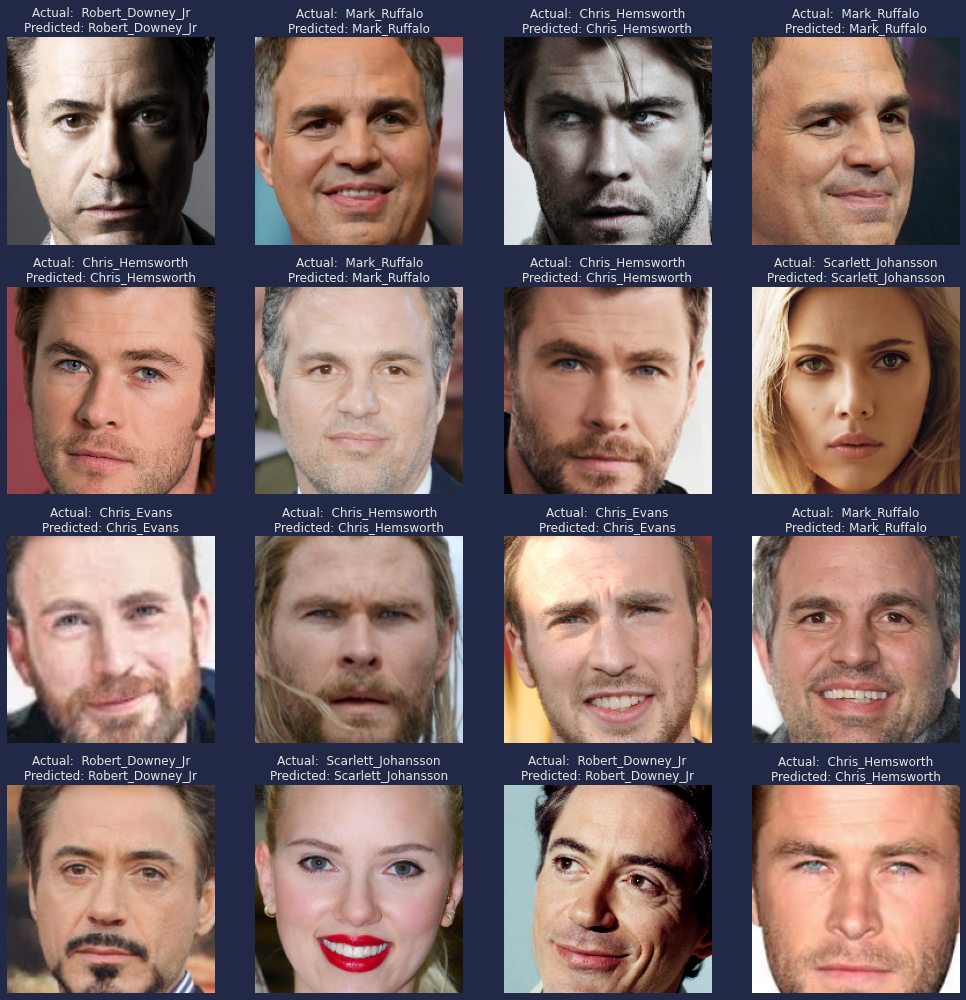

In [13]:
#Visualising a batch of image dataset

test_batch = [(x, y) for (x,y) in val_ds.take(1)] # loading 1 batch of data
image, label = test_batch[0][0], test_batch[0][1]

prediction = faces_model.predict(image)
prediction = np.argmax(prediction, axis=1)


plt.figure(figsize=[14,14])
for e in range(16):
    plt.subplot(4,4,e+1)
    plt.imshow(image[e].numpy().astype('uint8'))
    actual_label = name_class_map[class_map[label[e].numpy()]]
    prediction = faces_model.predict(np.expand_dims(image[e], axis=0))
    predicted_label = name_class_map[class_map[np.argmax(prediction)]]
    #predicted_label = np.argmax(saved_model.predict(image))
    plt.title('Actual:  {}\nPredicted: {}'.format(actual_label, predicted_label))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

---

#  **EMOTIONS MODEL**

In [14]:
# Read and prepare data
data = pd.read_csv('/kaggle/input/facialexpressionrecognition/fer2013.csv')
data.shape

(35887, 3)

In [15]:
# Create train and testing sets
train, test = train_test_split(data,
                               test_size = 0.3,
                               stratify=data['emotion'],
                               random_state=451
                              )

In [16]:
#check target labels
#classes and number
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


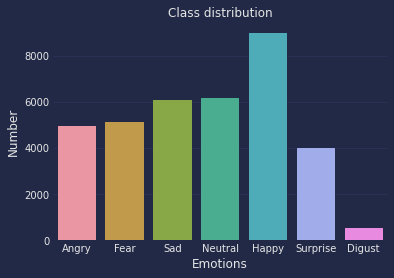

In [17]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

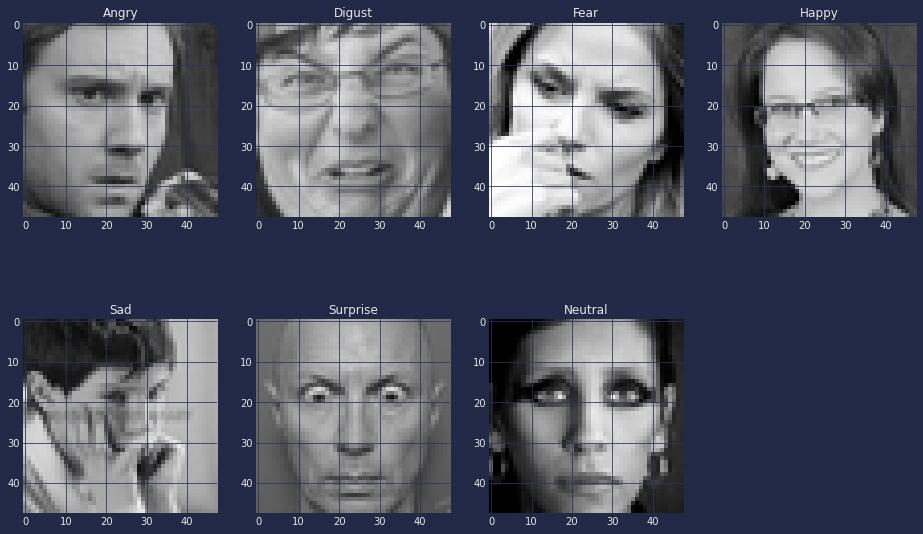

In [18]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

In [25]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [27]:
#split data into training, validation and test set
#to avoid overfitting
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


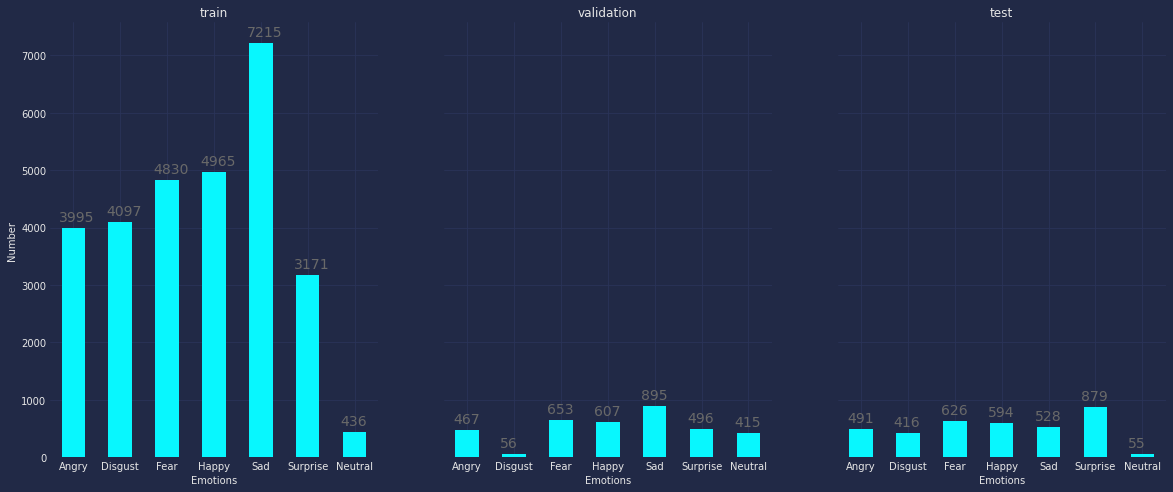

In [28]:
# Creating a barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [29]:
# CRNO is a function to Convert, Reshape, Normalize, One-hot encoding
# 1. Convert strings to lists of integers
# 2. Reshape and normalise grayscale image with 255.0
# 3. One-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [30]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)



In [31]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 256)       1024      
_________________________________________________________________
activation (Activation)      (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 256)      

In [32]:
history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/50
448/448 - 48s - loss: 1.7193 - accuracy: 0.3148 - val_loss: 1.8519 - val_accuracy: 0.2608
Epoch 2/50
448/448 - 42s - loss: 1.4286 - accuracy: 0.4491 - val_loss: 1.6371 - val_accuracy: 0.4110
Epoch 3/50
448/448 - 42s - loss: 1.2646 - accuracy: 0.5117 - val_loss: 1.3266 - val_accuracy: 0.4812
Epoch 4/50
448/448 - 42s - loss: 1.1824 - accuracy: 0.5499 - val_loss: 1.3745 - val_accuracy: 0.4739
Epoch 5/50
448/448 - 42s - loss: 1.1337 - accuracy: 0.5670 - val_loss: 1.1193 - val_accuracy: 0.5868
Epoch 6/50
448/448 - 43s - loss: 1.0930 - accuracy: 0.5826 - val_loss: 1.1377 - val_accuracy: 0.5759
Epoch 7/50
448/448 - 42s - loss: 1.0580 - accuracy: 0.5959 - val_loss: 1.1830 - val_accuracy: 0.5717
Epoch 8/50
448/448 - 43s - loss: 1.0324 - accuracy: 0.6086 - val_loss: 1.2647 - val_accuracy: 0.5313
Epoch 9/50
448/448 - 42s - loss: 1.0093 - accuracy: 0.6160 - val_loss: 1.0762 - val_accuracy: 0.5918
Epoch 10/50
448/448 - 43s - loss: 0.9843 - accuracy: 0.6285 - val_loss: 1.0712 - val_accura

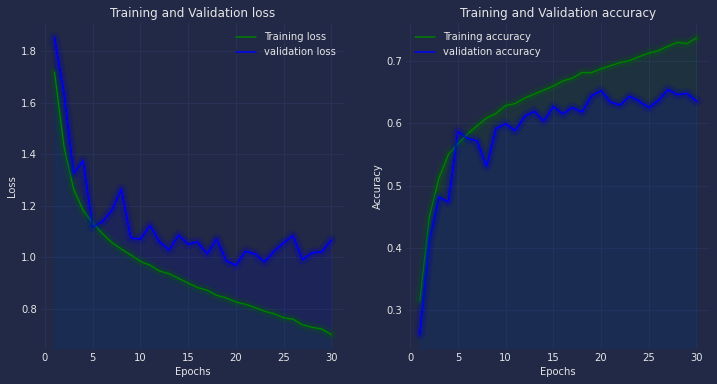

In [33]:
#Visualising model performance
acc_train_emotions = history.history['accuracy']
acc_val_emotions = history.history['val_accuracy']

loss_train_emotions = history.history['loss']
loss_val_emotions = history.history['val_loss']

epochs = range(1,len(loss_train_emotions)+1)
plt.figure(figsize=(12, 6))
plt.style.use('cyberpunk')
plt.subplot(1,2,1)
plt.plot(epochs, loss_train_emotions, 'g', label='Training loss')
plt.plot(epochs, loss_val_emotions, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
mplcyberpunk.add_glow_effects()

plt.subplot(1,2,2)
plt.plot(epochs, acc_train_emotions, 'g', label='Training accuracy')
plt.plot(epochs, acc_val_emotions, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
mplcyberpunk.add_glow_effects()
plt.show()

In [34]:
# saving the model
model.save('emotions_model.h5')

In [35]:
# Loading the saved model from checkpoint

emotions_model = tf.keras.models.load_model('emotions_model.h5')
emotions_model

# Predicting new images


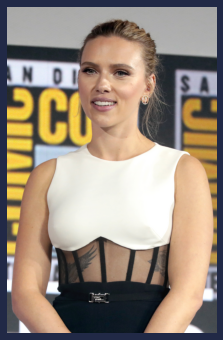

In [36]:
# Reading a sample image file
#urllib.request.urlretrieve("https://raw.githubusercontent.com/Masterx-AI/Project_Face_Recognition/main/robert.jpg", "robert.jpg")
urllib.request.urlretrieve("https://raw.githubusercontent.com/Masterx-AI/Project_Face_Recognition/main/face.xml", "face.xml")
urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/2/2a/Scarlett_Johansson_by_Gage_Skidmore_2_%28cropped%2C_2%29.jpg","scarlet.jpg")
img = cv2.imread('scarlet.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plotting the image
def plot_image(img, cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    
plot_image(img)
plt.show()

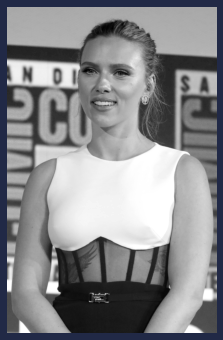

(3050, 1960)

In [37]:
# Converting the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plot_image(gray, cmap='gray')
plt.show()
gray.shape

In [38]:
# Implementing Cascade Classifier

face_cascade = cv2.CascadeClassifier('face.xml')

faces_rect = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10)

print(f'Number of face ===> {len(faces_rect)}')

Number of face ===> 1


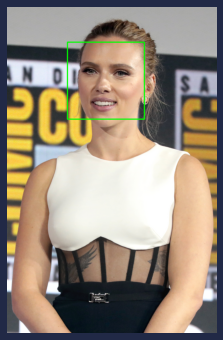

In [39]:
# Plotting the area of face detection

for (x,y,w,h) in faces_rect:
    cropped = img[y:y+h, x:x+w].copy()
    cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), thickness=10)
    
plot_image(img)

In [41]:
# Prediction
# gray image
img_2 = img.copy()
crop = cv2.resize(cropped, (img_height, img_width))
final_img = np.expand_dims(crop, axis=0)
# face Prediction                           
prediction_face = face_model.predict(final_img)
face_predicted_value = np.argmax(prediction_face)
face_predicted_value = np.argmax(prediction_face) if np.max(prediction) >= 0.4 else 'UNKNOWN'
if face_predicted_value == 'UNKNOWN':
    face_predicted_label = face_predicted_value
else :
    face_predicted_label = name_class_map[class_map[face_predicted_value]]
print(face_predicted_label)

Scarlett_Johansson


In [44]:
# gray image
cropped = cv2.resize(cropped, (width, height))  
gray_image = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
gray_image = np.expand_dims(gray_image, axis=-1)
input_image = gray_image.reshape((1, width, height, 1))
input_image = input_image / 255.0
# emotions Prediction
prediction_emotion = emotions_model.predict(input_image)
emotion_predicted_value = np.argmax(prediction_emotion)
emotion_predicted_label = emotion_labels[emotion_predicted_value]
print(emotion_predicted_label)

Happy


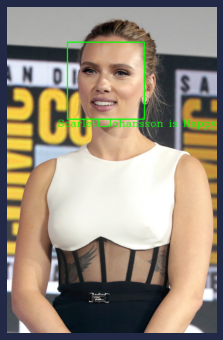

In [45]:
cv2.putText(img_2, face_predicted_label + " is "+emotion_predicted_label, (x-90,y+h+70), cv2.FONT_HERSHEY_COMPLEX, 3, (0,255,0), 3, cv2.LINE_AA)
    
plot_image(img_2)

In [46]:
print(face_predicted_label + " is "+emotion_predicted_label)

Scarlett_Johansson is Happy


**Testing the results of an unknown face**

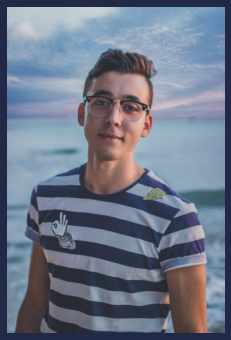

In [131]:
# Reading a sample image file
urllib.request.urlretrieve("https://scontent.ftun13-1.fna.fbcdn.net/v/t31.18172-8/23632667_2060279074194005_5742607091083966482_o.jpg?_nc_cat=110&ccb=1-7&_nc_sid=174925&_nc_ohc=6tGyYQkYcCEAX-8ibeF&_nc_ht=scontent.ftun13-1.fna&oh=00_AfDaKPO1KpWz7cWqn_-atBnkHvdG-HozFc6qBbl50a7c4w&oe=6499FBA5","habib.jpg")
habib = cv2.imread('habib.jpg')
habib = cv2.cvtColor(habib, cv2.COLOR_BGR2RGB)

# Plotting the image
def plot_image(habib, cmap=None):
    plt.imshow(habib, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    
plot_image(habib)
plt.show()

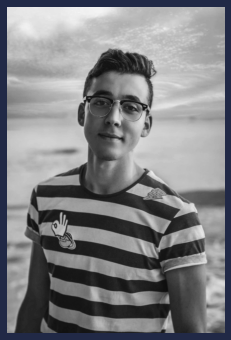

In [132]:
# Converting the image to grayscale
gray = cv2.cvtColor(habib, cv2.COLOR_BGR2GRAY)

plot_image(gray, cmap='gray')
plt.show()

In [133]:
# Implementing Cascade Classifier

face_cascade = cv2.CascadeClassifier('face.xml')

faces_rect = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10)

print(f'Number of face ===> {len(faces_rect)}')

Number of face ===> 1


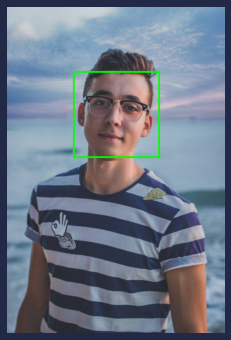

In [134]:
# Plotting the area of face detection

for (x,y,w,h) in faces_rect:
    cropped = habib[y:y+h, x:x+w].copy()
    cv2.rectangle(habib, (x,y), (x+w, y+h), (0,255,0), thickness=10)
    
plot_image(habib)

In [128]:
# Prediction
# gray image
img_2 = obama.copy()
crop = cv2.resize(cropped, (img_height, img_width))
final_img = np.expand_dims(crop, axis=0)
# face Prediction                           
prediction_face = face_model.predict(final_img)
if np.max(prediction_face) >= 0.5 :
    face_predicted_value = np.argmax(prediction_face)
    face_predicted_label = name_class_map[class_map[face_predicted_value]]
else :
    face_predicted_label ='UNKNOWN'
print(face_predicted_label)

UNKNOWN


In [129]:
# gray image
cropped = cv2.resize(cropped, (width, height))  
gray_image = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
gray_image = np.expand_dims(gray_image, axis=-1)
input_image = gray_image.reshape((1, width, height, 1))
input_image = input_image / 255.0
# emotions Prediction
prediction_emotion = emotions_model.predict(input_image)
emotion_predicted_value = np.argmax(prediction_emotion)
emotion_predicted_label = emotion_labels[emotion_predicted_value]
print(emotion_predicted_label)

Neutral


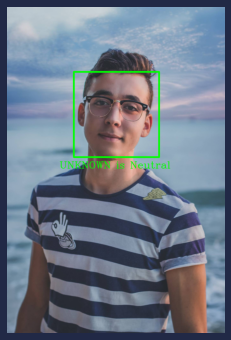

In [135]:
cv2.putText(habib, face_predicted_label + " is "+emotion_predicted_label, (x-90,y+h+70), cv2.FONT_HERSHEY_COMPLEX, 2, (0,255,0), 2, cv2.LINE_AA)
    
plot_image(habib)

In [136]:
print(face_predicted_label + " is "+emotion_predicted_label)

UNKNOWN is Neutral


* **Conclusion**

In this notebook, we developed a face and emotion recognition model using deep learning techniques. This model can recognize faces in images and predict the corresponding emotions associated with those faces.

To ensure consistent input to the model, we started preprocessing the input images, such as face detection and alignment. Next, we trained a CNN (Convolutional Neural Network) model using a sequential architecture. The model consists of several convolution and pooling layers followed by a fully connected layer for classification. 

The trained model showed promising performance in the face and emotion recognition. We achieved high accuracy on the validation set and demonstrated the ability to generalize well to unseen data. We evaluated the model using various metrics such as accuracy and loss to evaluate its performance.

Overall, the developed face and emotion recognition models demonstrate the power of deep learning in understanding and analyzing facial expressions. It can be further improved and extended by incorporating larger datasets, exploring advanced architectures, and fine-tuning hyperparameters. Potential applications of this model include sentiment analysis, the study of facial expressions, and human-computer interaction. 